# XGBoost Model
- Attempting to predict likelyhood of income either <=50K or >50K from 1994 Census database
- https://jessesw.com/XG-Boost/

# Setting up environment

In [1]:
%attachments

Training Cluster    ML Engine
------------------  -----------
te                  python


In [1]:
print('test7')

test7


In [2]:
%%te
print('test')

History URL: http://kdss-bs2wv-0.kdhs-sxzcn.ar.svc.cluster.local:10001/history/5


In [3]:
%logs --url http://kdss-bs2wv-0.kdhs-sxzcn.ar.svc.cluster.local:10001/history/5

Job Status: Finished
test




In [4]:
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
sns.set(font_scale=1.5)

%matplotlib inline 

In [9]:
def ProjectRepo(path):
   return str( '/bd-fs-mnt/project_repo'+ '/' + path)

# Data preprocessing

In [10]:
train_file = ProjectRepo('data/UCI_Income/adult_data.csv')
test_file = ProjectRepo('data/UCI_Income/adult_test.csv')

In [11]:
train_set = pd.read_csv(train_file, header=None)
train_set.head()

/bd-fs-mnt/project_repo/data/UCI_Income/adult_data.csv


0                  1       2           3   4                    5   \
0  39          State-gov   77516   Bachelors  13        Never-married   
1  50   Self-emp-not-inc   83311   Bachelors  13   Married-civ-spouse   
2  38            Private  215646     HS-grad   9             Divorced   
3  53            Private  234721        11th   7   Married-civ-spouse   
4  28            Private  338409   Bachelors  13   Married-civ-spouse   

                   6               7       8        9     10  11  12  \
0        Adm-clerical   Not-in-family   White     Male  2174   0  40   
1     Exec-managerial         Husband   White     Male     0   0  13   
2   Handlers-cleaners   Not-in-family   White     Male     0   0  40   
3   Handlers-cleaners         Husband   Black     Male     0   0  40   
4      Prof-specialty            Wife   Black   Female     0   0  40   

               13      14  
0   United-States   <=50K  
1   United-States   <=50K  
2   United-States   <=50K  
3   United-States   <=50K  
4            Cuba   <=50K

In [12]:
test_set = pd.read_csv(test_file, skiprows=1, header=None)
test_set.head()

0           1       2              3   4                    5   \
0  25     Private  226802           11th   7        Never-married   
1  38     Private   89814        HS-grad   9   Married-civ-spouse   
2  28   Local-gov  336951     Assoc-acdm  12   Married-civ-spouse   
3  44     Private  160323   Some-college  10   Married-civ-spouse   
4  18           ?  103497   Some-college  10        Never-married   

                   6           7       8        9     10  11  12  \
0   Machine-op-inspct   Own-child   Black     Male     0   0  40   
1     Farming-fishing     Husband   White     Male     0   0  50   
2     Protective-serv     Husband   White     Male     0   0  40   
3   Machine-op-inspct     Husband   Black     Male  7688   0  40   
4                   ?   Own-child   White   Female     0   0  30   

               13       14  
0   United-States   <=50K.  
1   United-States   <=50K.  
2   United-States    >50K.  
3   United-States    >50K.  
4   United-States   <=50K.

## Initial Findings
1. No column headers (can fix using dataset description from website)
2. Some "?" in test data 
3. Target values differ in train and test set

#### 1. Fix column headers

In [13]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

In [14]:
train_set.columns = col_labels
test_set.columns = col_labels

#### 2. Clean up ? in data

In [15]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [16]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16281 non-null  object
 14  wage_class      16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [17]:
train_set.replace(' ?', np.nan).dropna().shape

(30162, 15)

In [18]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

In [19]:
# removing rows with "?" from our dataframes 
train_no_missing = train_set.replace(' ?', np.nan).dropna()
test_no_missing = test_set.replace(' ?', np.nan).dropna()

#### 3. Fix targets (remove the extra periods from '<=50K.' to '<=50K')

In [20]:
test_no_missing['wage_class'] = test_no_missing.wage_class.replace({' <=50K.' : ' <=50K', ' >50K.' : ' >50K'})

In [21]:
test_no_missing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [22]:
train_no_missing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

## Applying ordinal encoding to categoricals
- ordinal encoding: convert string labels to integer values 1 through k. First unique value in column becomes 1, the second becomes 2, the third becomes 3, adn so on


In [23]:
#combine the datasets together first
combined_set = pd.concat([train_no_missing, test_no_missing], axis=0)
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education_num   45222 non-null  int64 
 5   marital_status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital_gain    45222 non-null  int64 
 11  capital_loss    45222 non-null  int64 
 12  hours_per_week  45222 non-null  int64 
 13  native_country  45222 non-null  object
 14  wage_class      45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [24]:
#Visualizations after initial cleaning of dataset 
group = combined_set.groupby('wage_class')
group

In [25]:
#encode non-numerical features into numeric values using pandas Cateogrical codes 
#and generating categorical codes mapping into dictionary
cat_codes = {}
for feature in combined_set.columns: 
    if combined_set[feature].dtype == 'object':
        #workclass : { occupation : number }
        temp_dict = {}
        feature_codes = list(pd.Categorical(combined_set[feature]).codes)
        feature_list = list(combined_set[feature])
        for i in range(len(feature_codes)):
            temp_dict[feature_list[i].strip()] = int(feature_codes[i])
            if len(temp_dict) > len(feature_list):
                break
        cat_codes[feature] = temp_dict
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             45222 non-null  int64
 1   workclass       45222 non-null  int8 
 2   fnlwgt          45222 non-null  int64
 3   education       45222 non-null  int8 
 4   education_num   45222 non-null  int64
 5   marital_status  45222 non-null  int8 
 6   occupation      45222 non-null  int8 
 7   relationship    45222 non-null  int8 
 8   race            45222 non-null  int8 
 9   sex             45222 non-null  int8 
 10  capital_gain    45222 non-null  int64
 11  capital_loss    45222 non-null  int64
 12  hours_per_week  45222 non-null  int64
 13  native_country  45222 non-null  int8 
 14  wage_class      45222 non-null  int8 
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


In [26]:
# saving encoding to json file to be used for scoring script
json_file = ProjectRepo('data/UCI_Income/encoding.json')
with open(json_file, 'w') as file:
    json.dump(cat_codes, file)

In [27]:
#split combined set back into test/train split 
final_train = combined_set[:train_no_missing.shape[0]] 
final_test = combined_set[train_no_missing.shape[0]:]
final_train.to_csv(ProjectRepo('data/UCI_Income/adult_train_cleaned.csv'))
final_test.to_csv(ProjectRepo('data/UCI_Income/adult_test_cleaned.csv'))

In [28]:
#extracting target values from our test and train sets 
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

# Model Development

In [29]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

### First model

In [30]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_Rate': 0.1, 'n_estimators': 1000, 'seed': 0, 'subsample' : 0.8, 'colsample_bytree': 0.8, 
              'objective': 'binary:logistic'}

#optimizing for accuracy, GBM = gradient boost model
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

In [31]:
optimized_GBM.fit(final_train, y_train)

[11:01:22] WARNING: ../src/learner.cc:516: 
Parameters: { learning_Rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_Rate=0.1, learning_rate=None,
                                     max_delta_step=None, max_depth=None,
                                     min_child_weight=None, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=0,
      

In [32]:
optimized_GBM.cv_results_

{'mean_fit_time': array([100.45855846, 100.91575627, 102.00310469, 158.04239683,
        159.3825747 , 154.20147772, 213.27617207, 178.94728227,
        113.91196065]),
 'std_fit_time': array([ 0.48243416,  0.92205547,  3.48246998,  3.67697393,  3.64268795,
         3.47748345,  1.7990269 , 20.04228056, 25.95372305]),
 'mean_score_time': array([1.65701723, 1.60094771, 1.67770243, 2.95986862, 2.7196403 ,
        2.89695673, 5.55871553, 2.90602999, 0.93791542]),
 'std_score_time': array([0.07863971, 0.05986791, 0.07244595, 0.09863915, 0.11556042,
        0.09212678, 0.29390928, 1.1613678 , 0.48603925]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
                  

### Second model
Tuning other hyperparameters in an attempt to achieve higher mean accuracy

In [33]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]}
ind_params = {'n_estimators': 1000, 'seed': 0, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 
              'max_depth': 3, 'min_child_weight': 1}
                    
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', cv=5, n_jobs=-1)
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=0,
                                     subsample=None, tree_method=Non

In [34]:
optimized_GBM.cv_results_

{'mean_fit_time': array([106.36171007, 100.59184766,  96.81506047, 109.68051424,
         94.12440729,  40.65545239]),
 'std_fit_time': array([ 1.18686079,  2.19544098,  0.90036712,  1.62713195, 21.70446604,
         6.57264023]),
 'mean_score_time': array([1.54270124, 1.58207893, 1.38867927, 1.28340039, 1.13494506,
        0.27114224]),
 'std_score_time': array([0.10018177, 0.09339733, 0.12701663, 0.19573663, 0.39166144,
        0.12194934]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.7, 0.8, 0.9, 0.7, 0.8, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1, 'subsample': 0.7},
  {'learning_rate': 0.1, 'subsample': 0.8},
  {'learning_rate': 0.1, 'subsample': 0.9},
  {'learning_rate': 0.01, 'subsam

### Third model
Utilize XGBoost's built-in cv which allows early stopping to prevent overfitting

In [35]:
xgdmat = xgb.DMatrix(final_train, y_train)

In [36]:
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic',
              'max_depth': 3, 'min_child_weight': 1}

cv_xgb = xgb.cv(params=our_params, dtrain=xgdmat, num_boost_round=3000, metrics=['error'],
                early_stopping_rounds=100)

In [37]:
print('Best iteration:', len(cv_xgb))

Best iteration: 326


In [38]:
cv_xgb.tail(5)

train-error-mean  train-error-std  test-error-mean  test-error-std
321          0.118543         0.001480         0.131623        0.001742
322          0.118610         0.001445         0.131324        0.001883
323          0.118526         0.001422         0.131291        0.001763
324          0.118643         0.001401         0.131391        0.001688
325          0.118693         0.001343         0.131158        0.001922

### Final Model

In [39]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 326)

# Plot feature importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

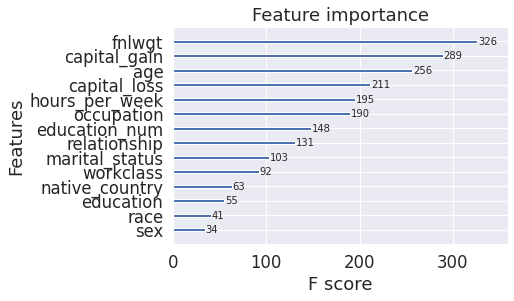

In [40]:
xgb.plot_importance(final_gb)

In [41]:
importances = final_gb.get_fscore()
importances

{'relationship': 131,
 'education_num': 148,
 'capital_gain': 289,
 'age': 256,
 'hours_per_week': 195,
 'education': 55,
 'fnlwgt': 326,
 'capital_loss': 211,
 'marital_status': 103,
 'sex': 34,
 'occupation': 190,
 'workclass': 92,
 'native_country': 63,
 'race': 41}

<AxesSubplot:ylabel='Feature'>

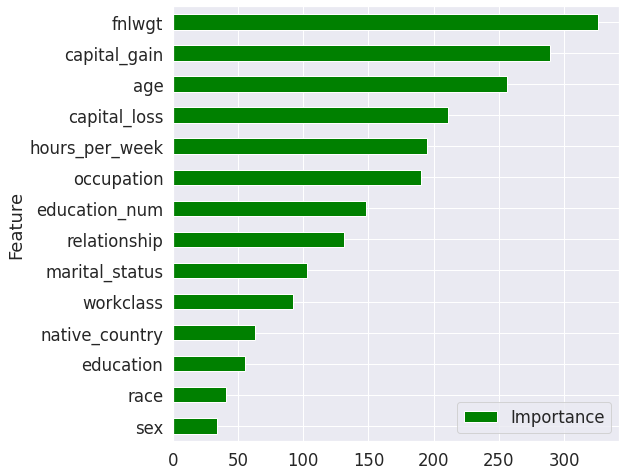

In [42]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace=True)
importance_frame.plot(kind='barh', x='Feature', figsize=(8,8), color='green')

# Build model remotely on a distributed Python deep learning cluster on larger dataset 

In [43]:
%%te

# Importing libraries 
print("Importing libraries")
import numpy as np
import pandas as pd
import os
import pickle
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV

# Start time 
print("Start time: ", datetime.datetime.now())

# Project repo path function
def ProjectRepo(path):
   return str( '/bd-fs-mnt/project_repo'+ '/' + path)

# Reading in data 
print("Reading in data")
train = pd.read_csv(ProjectRepo('data/UCI_Income/adult_train_cleaned.csv'))
print("Done reading in data")

# Extracting target values 
y_train = train.pop('wage_class')

# Model development / Training
print("Training...")
xgdmat = xgb.DMatrix(train, y_train)
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic',
              'max_depth': 3, 'min_child_weight': 1}
cv_xgb = xgb.cv(params=our_params, dtrain=xgdmat, num_boost_round=3000, metrics=['error'],
                early_stopping_rounds=100)
optimal_rounds = len(cv_xgb)
final_gb = xgb.train(our_params, xgdmat, num_boost_round = optimal_rounds)

# Save model into project repo
print("Saving model")
final_gb.save_model(ProjectRepo('models/XGB_Income/XGB.model'))

# Finish time
print("End time: ", datetime.datetime.now())

History URL: http://kdss-8mr9s-0.kdhs-sxzcn.ar.svc.cluster.local:10001/history/6


In [46]:
%logs --url http://kdss-8mr9s-0.kdhs-sxzcn.ar.svc.cluster.local:10001/history/6

Job Status: Finished
Importing libraries
Start time:  2020-09-30 11:23:31.701061
Reading in data
Done reading in data
Training...
Saving model
End time:  2020-09-30 11:24:51.978033




# Testing scoring with generated model 

In [47]:
cleaned = pd.read_csv(ProjectRepo('data/UCI_Income/adult_test_cleaned.csv'))
cleaned.tail(1)

Unnamed: 0  age  workclass  fnlwgt  education  education_num  \
15059       16280   35          3  182148          9             13   

       marital_status  occupation  relationship  race  sex  capital_gain  \
15059               2           3             0     4    1             0   

       capital_loss  hours_per_week  native_country  wage_class  
15059             0              60              38           1

In [48]:
#Running with final_gb model from local notebook 
temp = cleaned.tail(1)
y_test = temp.pop('wage_class')
temp.set_index('age')
temp.pop('Unnamed: 0')
mat = xgb.DMatrix(temp) 
y_pred = final_gb.predict(mat)
y_pred

array([0.8078612], dtype=float32)

In [49]:
#Running with loaded model 
temp_gb = xgb.Booster({'nthread':325})
temp_gb.load_model(ProjectRepo('models/XGB_Income/XGB.model'))
temp = cleaned.tail(1)
y_test = temp.pop('wage_class')
temp.set_index('age')
temp.pop('Unnamed: 0')
mat = xgb.DMatrix(temp) 
y_pred = temp_gb.predict(mat)
y_pred

array([0.00645629], dtype=float32)

## Observations
- save_model function doesn't save the optimized model, only saves the last iteration
- need to rebuild model and save as pickle file 

# Same model construction, but saving model as pickle instead
- Using xgb.save_model doesn't save the best iteration of the training 
- Trying to save as pickle file instead 

In [50]:
%%te

# Importing libraries 
print("Importing libraries")
import numpy as np
import pandas as pd
import os
import pickle
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV

# Start time 
print("Start time: ", datetime.datetime.now())

# Project repo path function
def saveInProjectRepo(path):
   return str( '/bd-fs-mnt/project_repo'+ '/' + path)

# Reading in data 
print("Reading in data")
train = pd.read_csv(saveInProjectRepo('data/UCI_Income/adult_train_cleaned.csv'))
print("Done reading in data")

# Extracting target values 
y_train = train.pop('wage_class')
train.pop('Unnamed: 0')

# Model development / Training
print("Training...")
xgdmat = xgb.DMatrix(train, y_train)
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic',
              'max_depth': 3, 'min_child_weight': 1}
cv_xgb = xgb.cv(params=our_params, dtrain=xgdmat, num_boost_round=3000, metrics=['error'],
                early_stopping_rounds=100)
optimal_rounds = len(cv_xgb)
final_gb = xgb.train(our_params, xgdmat, num_boost_round = optimal_rounds)

# Save model into project repo
print("Saving model")
# pickle.dump(final_gb, open( saveInProjectRepo('models/XGB_Income/') + "XGB.pickle.dat", "wb"))
xgb.Booster.save_model(final_gb, saveInProjectRepo('models/XGB_Income/') + "XGB.pickle.dat")

# Finish time
print("End time: ", datetime.datetime.now())

History URL: http://kdss-bs2wv-0.kdhs-sxzcn.ar.svc.cluster.local:10001/history/7


In [54]:
%logs --url http://kdss-bs2wv-0.kdhs-sxzcn.ar.svc.cluster.local:10001/history/7

Job Status: Finished
Importing libraries
Start time:  2020-09-30 11:26:11.111429
Reading in data
Done reading in data
Training...
Saving model
End time:  2020-09-30 11:29:39.326853




# Testing with loading pickle model 

Using scoring with pickle model yields proper results

In [55]:
model = xgb.Booster({'nthread':325})
model.load_model(ProjectRepo('models/XGB_Income/XGB.pickle.dat'))
temp = cleaned.tail(1)
y_test = temp.pop('wage_class')
temp.set_index('age')
temp.pop('Unnamed: 0')
mat = xgb.DMatrix(temp) 
y_pred = model.predict(mat)
y_pred

array([0.80730987], dtype=float32)